<a href="https://colab.research.google.com/github/Stanmatkovskyi/CSP-Project-Combat-Simulator/blob/main/CSP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Combat ended after 155 time steps.
Army2 wins with surviving units:
[INF(HP:54), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120)]
36


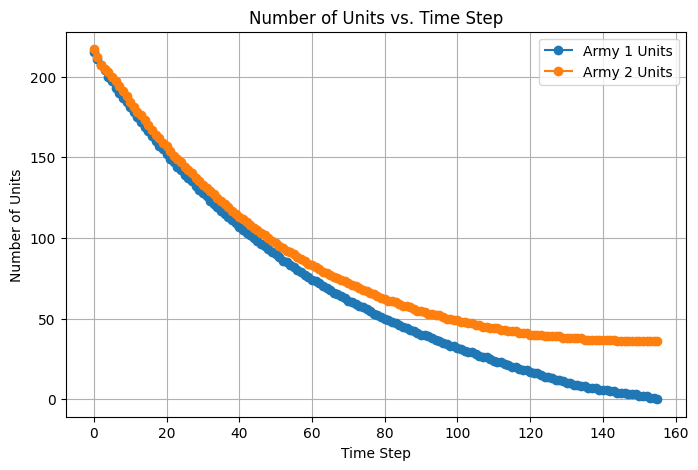

In [ ]:
#New version with toggable feature of efficiency scaling with health
#Effective efficiency calculated as: Effective efficiency = Base Efficiency * (Current Health / Max Health)
#Should lead to even finer approxiamtions of Lanchester Model
# New optimization feature - secondary sort explicitly prioritizing already damaged units, thus enforcing coordination
# Example scenario is still battle of Somme
import random
import matplotlib.pyplot as plt

# Global flag: if True, scale a unit's efficiency by (current health / max health)
SCALE_EFFICIENCY = False

# -----------------------------
# Unit Class Definition
# -----------------------------
class Unit:
    def __init__(self, unit_type, health, efficiencies):
        """
        :param unit_type: String identifier (e.g. "A", "B", "X", "Y").
        :param health: Initial (and maximum) health points.
        :param efficiencies: Dictionary mapping enemy types to base damage per timestep.
                             E.g., {"X": 2, "Y": 3} means 2 damage vs. X and 3 vs. Y.
        """
        self.unit_type = unit_type
        self.health = health
        self.max_health = health
        self.efficiencies = efficiencies

    def __repr__(self):
        return f"{self.unit_type}(HP:{self.health})"

# -----------------------------
# Helper: Compute Composition
# -----------------------------
def compute_composition(army):
    """
    Returns a tuple (composition, total) where composition is a dict mapping unit types to counts.
    """
    comp = {}
    for unit in army:
        comp[unit.unit_type] = comp.get(unit.unit_type, 0) + 1
    return comp, len(army)

# -----------------------------
# Helper: Efficiency Scaling
# -----------------------------
def get_scaled_efficiency(unit, key):
    """
    Returns the effective efficiency for a unit for a given enemy type key.
    If SCALE_EFFICIENCY is True, scales by (current health / max_health).
    """
    base = unit.efficiencies[key]
    return base * (unit.health / unit.max_health) if SCALE_EFFICIENCY else base

# -----------------------------
# Helper: Damage Allocation (Killable Feature)
# -----------------------------
def allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose=False):
    """
    Given an ordered list of enemy targets (ordered highest score first), allocate the attacker's fixed damage.
    If any target can be killed with the remaining damage, allocate exactly its remaining health.
    Otherwise, assign all remaining damage to the top candidate.
    """
    damage_left = attack_power
    while damage_left > 0 and ordered_targets:
        killable = [enemy for enemy in ordered_targets if remaining_health[enemy] <= damage_left]
        if killable:
            for enemy in ordered_targets:
                if remaining_health[enemy] <= damage_left:
                    alloc = remaining_health[enemy]
                    allocated_damage[enemy] += alloc
                    damage_left -= alloc
                    remaining_health[enemy] = 0
                    if verbose:
                        print(f"    Allocated {alloc} damage to {enemy} (killed)")
                    ordered_targets.remove(enemy)
                    break
        else:
            enemy = ordered_targets[0]
            alloc = min(damage_left, remaining_health[enemy])
            allocated_damage[enemy] += alloc
            remaining_health[enemy] -= alloc
            damage_left -= alloc
            if verbose:
                print(f"    Allocated {alloc} damage to {enemy} (not killed)")
            if remaining_health[enemy] <= 0:
                ordered_targets.remove(enemy)
    return allocated_damage

# -----------------------------
# OLD (Non‑Health Adjusted) Policies (with explicit health prioritization and optional scaling)
# -----------------------------
def old_most_efficient(attacking_army, enemy_army, verbose=False):
    """
    Orders enemy units by the attacker's (scaled) efficiency against them,
    with secondary sort by 1/enemy.health.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(attacker, enemy.unit_type), 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD most_efficient targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_most_dangerous(attacking_army, enemy_army, verbose=False):
    """
    Orders enemy units by the enemy's (scaled) danger against the attacker,
    with secondary sort by 1/enemy.health.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        # For danger, use get_scaled_efficiency on enemy.
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(enemy, attacker.unit_type), 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD most_dangerous targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_product(attacking_army, enemy_army, verbose=False):
    """
    For each attacker, compute:
      effective_vulnerability = get_scaled_efficiency(attacker, enemy.unit_type)
      effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
      product = effective_vulnerability * effective_danger.
    Order targets by (product, 1/enemy.health) descending.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type)
            effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
            product = effective_vul * effective_danger
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD product targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_weighted_product(attacking_army, enemy_army, verbose=False):
    """
    Computes weighted danger for each enemy as:
         weighted_danger = (Σ [get_scaled_efficiency(enemy, t) * count(t)]) / (total attackers)
    For each attacker, effective_vulnerability = get_scaled_efficiency(attacker, enemy.unit_type).
    Then product = weighted_danger * effective_vulnerability.
    Order targets by (product, 1/enemy.health) descending.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type)
            product = enemy_weighted_danger[enemy] * effective_vul
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD weighted_product targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} weighted product: {prod:.2f}, 1/health: {invh:.2f} (weighted danger: {enemy_weighted_danger[enemy]:.2f})")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_weighted_danger(attacking_army, enemy_army, verbose=False):
    """
    Orders enemy targets solely by their weighted danger computed as:
         weighted_danger = (Σ [get_scaled_efficiency(enemy, t) * count(t)]) / (total attackers)
    with secondary sort 1/enemy.health.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (enemy_weighted_danger[enemy], 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD weighted_danger targets:")
            for enemy in ordered_targets:
                print(f"  {enemy} weighted danger: {enemy_weighted_danger[enemy]:.2f}, 1/health: {1/enemy.health:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

# -----------------------------
# NEW (Health‑Adjusted) Policies (with efficiency scaling applied as well)
# -----------------------------
def new_most_efficient_health(attacking_army, enemy_army, verbose=False):
    """
    Orders enemy targets by (get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health),
    with secondary sort by 1/enemy.health.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health, 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW most_efficient_health targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_most_dangerous_health(attacking_army, enemy_army, verbose=False):
    """
    Orders enemy targets by (get_scaled_efficiency(enemy, attacker.unit_type) / enemy.health),
    with secondary sort by 1/enemy.health.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(enemy, attacker.unit_type) / enemy.health, 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW most_dangerous_health targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_product_health(attacking_army, enemy_army, verbose=False):
    """
    For each attacker, compute:
      effective_vulnerability = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health
      effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
      product = effective_vulnerability * effective_danger.
    Order targets by (product, 1/enemy.health) descending.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health
            effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
            product = effective_vul * effective_danger
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW product_health targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_weighted_product_health(attacking_army, enemy_army, verbose=False):
    """
    For each enemy, compute weighted danger as:
      weighted_danger = (Σ_{t in attacker types} [ get_scaled_efficiency(enemy, t) * count(t) ]) / (total attackers)
    For each attacker, effective_vulnerability = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health.
    Then product = weighted_danger * effective_vulnerability.
    Order targets by (product, 1/enemy.health) descending.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health
            product = enemy_weighted_danger[enemy] * effective_vul
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW weighted_product_health targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} weighted product: {prod:.2f}, 1/health: {invh:.2f} (weighted danger: {enemy_weighted_danger[enemy]:.2f})")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_weighted_danger_health(attacking_army, enemy_army, verbose=False):
    """
    Orders enemy targets solely by their weighted danger computed as:
      weighted_danger = (Σ_{t in attacker types} [ get_scaled_efficiency(enemy, t) * count(t) ]) / (total attackers)
      then health adjusted score is weighted_danger / enemy.health
    with secondary sort by 1/enemy.health.
    """
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (enemy_weighted_danger[enemy]/enemy.health, 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW weighted_danger_health targets:")
            for enemy in ordered_targets:
                print(f"  {enemy} weighted danger: {enemy_weighted_danger[enemy]:.2f}, 1/health: {1/enemy.health:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

# -----------------------------
# Simulation Function
# -----------------------------
def simulate_combat(army1, army2, policy_army1, policy_army2, verbose=False):
    """
    Simulates combat between two armies using the specified targeting policy functions.
    The simulation runs in discrete time steps until one army is eliminated.
    Returns (steps, remaining_army1, remaining_army2, history), where history records surviving units per timestep.
    """
    step = 0
    history = {'steps': [], 'army1_counts': [], 'army2_counts': []}
    history['steps'].append(step)
    history['army1_counts'].append(len(army1))
    history['army2_counts'].append(len(army2))

    while army1 and army2:
        if verbose:
            print(f"\nTime Step {step}:")
            print(f" Army1: {army1}")
            print(f" Army2: {army2}")
        damage_to_army2 = policy_army1(army1, army2, verbose=verbose)
        damage_to_army1 = policy_army2(army2, army1, verbose=verbose)

        new_army1 = []
        for unit in army1:
            dmg = damage_to_army1.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army1 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army1.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")
        new_army2 = []
        for unit in army2:
            dmg = damage_to_army2.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army2 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army2.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")
        army1, army2 = new_army1, new_army2
        step += 1
        history['steps'].append(step)
        history['army1_counts'].append(len(army1))
        history['army2_counts'].append(len(army2))

    return step, army1, army2, history

# -----------------------------
# Main Function & Policy Selection
# -----------------------------
def main():
    # Define armies.
   # Army 1:
    army1 = (
            [Unit("INF", 120, {"INF": 1, "MBT": 0.5, "DRN": 2}) for _ in
             range(200)] +  # Infantry Squad
            [Unit("MBT", 200, {"INF": 2, "MBT": 2, "DRN": 1}) for _ in
             range(8)] +  # Main Battle Tank
            [Unit("ADT", 100, {"INF": 1, "MBT": 1, "DRN": 3}) for _ in range(7)]  # Anti-Drone Team
    )

    # Army 2:
    army2 = (
            [Unit("INF", 120, {"INF": 1, "MBT": 0.5, "ADT": 2}) for _ in
             range(200)] +  # Infantry Section
            [Unit("MBT", 180, {"INF": 2, "MBT": 1.5, "ADT": 1}) for _ in
             range(7)] +  # Armored Vehicle
            [Unit("DRN", 80, {"INF": 3, "MBT": 1, "ADT": 2}) for _ in range(10)]
    )

    # Dictionary mapping new policies (health-adjusted with scaling) to functions.
    new_policies = {
        "most_efficient": new_most_efficient_health,
        "most_dangerous": new_most_dangerous_health,
        "product": new_product_health,
        "weighted_product": new_weighted_product_health,
        "weighted_danger": new_weighted_danger_health
    }

    # Dictionary mapping old policies (non-health-adjusted scoring but with explicit health prioritization)
    # with optional scaling applied.
    old_policies = {
        "most_efficient": old_most_efficient,
        "most_dangerous": old_most_dangerous,
        "product": old_product,
        "weighted_product": old_weighted_product,
        "weighted_danger": old_weighted_danger
    }

    # You can choose either set for each army.
    # For example, here Army1 uses the NEW "most_efficient_health" policy and Army2 uses NEW "weighted_product_health".
    policy_army1 = old_policies["weighted_danger"]
    policy_army2 = old_policies["most_efficient"]

    # Uncomment below to use old policies instead:
    # policy_army1 = old_policies["most_efficient"]
    # policy_army2 = old_policies["weighted_product"]

    # Set verbose=True to print per-timestep details.
    steps, remaining_army1, remaining_army2, history = simulate_combat(
        army1, army2, policy_army1, policy_army2, verbose=False
    )

    print(f"\nCombat ended after {steps} time steps.")
    if remaining_army1:
        print("Army1 wins with surviving units:")
        print(remaining_army1)
        print(len(remaining_army1))
    elif remaining_army2:
        print("Army2 wins with surviving units:")
        print(remaining_army2)
        print(len(remaining_army2))
    else:
        print("Both armies have been completely destroyed.")

    # Plot evolution of unit counts.
    plt.figure(figsize=(8, 5))
    plt.plot(history['steps'], history['army1_counts'], marker='o', label="Army 1 Units")
    plt.plot(history['steps'], history['army2_counts'], marker='o', label="Army 2 Units")
    plt.xlabel("Time Step")
    plt.ylabel("Number of Units")
    plt.title("Number of Units vs. Time Step")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()



Results Table: (Surviving units Army1, Surviving units Army2)
                     old_most_efficient old_most_dangerous old_product  \
old_most_efficient               (0, 7)            (41, 0)     (40, 0)   
old_most_dangerous              (0, 39)            (16, 0)     (0, 32)   
old_product                     (0, 45)            (30, 0)     (13, 0)   
old_weighted_product            (0, 36)            (30, 0)     (0, 21)   
old_weighted_danger             (0, 39)            (16, 0)     (0, 32)   
new_most_efficient               (0, 7)            (41, 0)     (40, 0)   
new_most_dangerous              (0, 30)            (23, 0)     (0, 16)   
new_product                     (0, 26)            (39, 0)     (19, 0)   
new_weighted_product            (0, 26)            (39, 0)     (22, 0)   
new_weighted_danger             (0, 30)            (23, 0)     (0, 17)   

                     old_weighted_product old_weighted_danger  \
old_most_efficient                (38, 0)             (41,

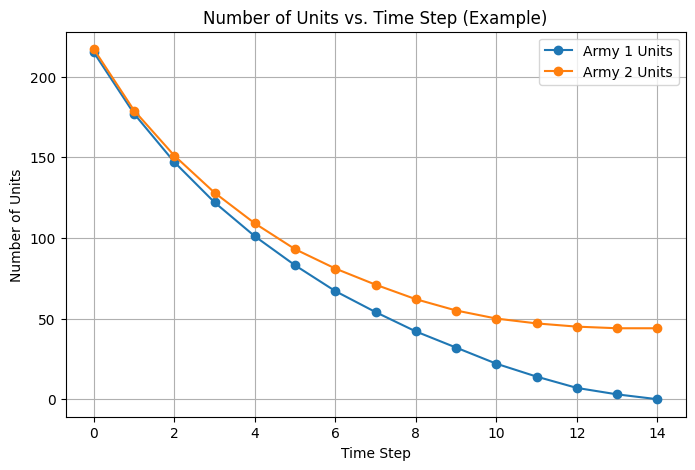

In [ ]:
# version that represents policy combinations as normal (matrix) form game
import random
import matplotlib.pyplot as plt
import pandas as pd

# Global flag: if True, scale a unit's efficiency by (current health / max health)
SCALE_EFFICIENCY = True

# -----------------------------
# Unit Class Definition
# -----------------------------
class Unit:
    def __init__(self, unit_type, health, efficiencies):
        """
        :param unit_type: String identifier (e.g. "A", "B", "X", "Y").
        :param health: Initial (and maximum) health points.
        :param efficiencies: Dictionary mapping enemy types to base damage per timestep.
                             E.g., {"X": 2, "Y": 3} means 2 damage vs. X and 3 vs. Y.
        """
        self.unit_type = unit_type
        self.health = health
        self.max_health = health
        self.efficiencies = efficiencies

    def __repr__(self):
        return f"{self.unit_type}(HP:{self.health})"

# -----------------------------
# Helper: Compute Composition
# -----------------------------
def compute_composition(army):
    """
    Returns a tuple (composition, total) where composition is a dict mapping unit types to counts.
    """
    comp = {}
    for unit in army:
        comp[unit.unit_type] = comp.get(unit.unit_type, 0) + 1
    return comp, len(army)

# -----------------------------
# Helper: Efficiency Scaling
# -----------------------------
def get_scaled_efficiency(unit, key):
    """
    Returns the effective efficiency for a unit for a given enemy type key.
    If SCALE_EFFICIENCY is True, scales by (current health / max_health).
    """
    base = unit.efficiencies[key]
    return base * (unit.health / unit.max_health) if SCALE_EFFICIENCY else base

# -----------------------------
# Helper: Damage Allocation (Killable Feature)
# -----------------------------
def allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose=False):
    """
    Given an ordered list of enemy targets (ordered highest score first), allocate the attacker's fixed damage.
    If any target can be killed with the remaining damage, allocate exactly its remaining health.
    Otherwise, assign all remaining damage to the top candidate.
    """
    damage_left = attack_power
    while damage_left > 0 and ordered_targets:
        killable = [enemy for enemy in ordered_targets if remaining_health[enemy] <= damage_left]
        if killable:
            for enemy in ordered_targets:
                if remaining_health[enemy] <= damage_left:
                    alloc = remaining_health[enemy]
                    allocated_damage[enemy] += alloc
                    damage_left -= alloc
                    remaining_health[enemy] = 0
                    if verbose:
                        print(f"    Allocated {alloc} damage to {enemy} (killed)")
                    ordered_targets.remove(enemy)
                    break
        else:
            enemy = ordered_targets[0]
            alloc = min(damage_left, remaining_health[enemy])
            allocated_damage[enemy] += alloc
            remaining_health[enemy] -= alloc
            damage_left -= alloc
            if verbose:
                print(f"    Allocated {alloc} damage to {enemy} (not killed)")
            if remaining_health[enemy] <= 0:
                ordered_targets.remove(enemy)
    return allocated_damage

# -----------------------------
# OLD (Non‑Health Adjusted) Policies
# -----------------------------
def old_most_efficient(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(attacker, enemy.unit_type), 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD most_efficient targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_most_dangerous(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(enemy, attacker.unit_type), 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD most_dangerous targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_product(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type)
            effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
            product = effective_vul * effective_danger
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD product targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_weighted_product(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type)
            product = enemy_weighted_danger[enemy] * effective_vul
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD weighted_product targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} weighted product: {prod:.2f}, 1/health: {invh:.2f} (weighted danger: {enemy_weighted_danger[enemy]:.2f})")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_weighted_danger(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (enemy_weighted_danger[enemy], 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD weighted_danger targets:")
            for enemy in ordered_targets:
                print(f"  {enemy} weighted danger: {enemy_weighted_danger[enemy]:.2f}, 1/health: {1/enemy.health:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

# -----------------------------
# NEW (Health‑Adjusted) Policies
# -----------------------------
def new_most_efficient_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health, 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW most_efficient_health targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_most_dangerous_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(enemy, attacker.unit_type) / enemy.health, 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW most_dangerous_health targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_product_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health
            effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
            product = effective_vul * effective_danger
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW product_health targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_weighted_product_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health
            product = enemy_weighted_danger[enemy] * effective_vul
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW weighted_product_health targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} weighted product: {prod:.2f}, 1/health: {invh:.2f} (weighted danger: {enemy_weighted_danger[enemy]:.2f})")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_weighted_danger_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (enemy_weighted_danger[enemy]/enemy.health, 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW weighted_danger_health targets:")
            for enemy in ordered_targets:
                print(f"  {enemy} weighted danger: {enemy_weighted_danger[enemy]:.2f}, 1/health: {1/enemy.health:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

# -----------------------------
# Combat Simulation Function
# -----------------------------
def simulate_combat(army1, army2, policy_army1, policy_army2, verbose=False):
    """
    Simulates combat between two armies using the specified targeting policy functions.
    The simulation runs in discrete time steps until one army is eliminated.
    Returns (steps, remaining_army1, remaining_army2, history).
    """
    step = 0
    history = {'steps': [], 'army1_counts': [], 'army2_counts': []}
    history['steps'].append(step)
    history['army1_counts'].append(len(army1))
    history['army2_counts'].append(len(army2))

    while army1 and army2:
        if verbose:
            print(f"\nTime Step {step}:")
            print(f" Army1: {army1}")
            print(f" Army2: {army2}")
        damage_to_army2 = policy_army1(army1, army2, verbose=verbose)
        damage_to_army1 = policy_army2(army2, army1, verbose=verbose)

        new_army1 = []
        for unit in army1:
            dmg = damage_to_army1.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army1 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army1.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")
        new_army2 = []
        for unit in army2:
            dmg = damage_to_army2.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army2 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army2.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")
        army1, army2 = new_army1, new_army2
        step += 1
        history['steps'].append(step)
        history['army1_counts'].append(len(army1))
        history['army2_counts'].append(len(army2))

    return step, army1, army2, history

# -----------------------------
# Functions to Create Fresh Armies
# -----------------------------
def create_army1():
    return ([Unit("INF", 12, {"INF": 1, "MBT": 0.5, "DRN": 2}) for _ in range(200)] +
            [Unit("MBT", 20, {"INF": 2, "MBT": 2, "DRN": 1}) for _ in range(8)] +
            [Unit("ADT", 10, {"INF": 1, "MBT": 1, "DRN": 3}) for _ in range(7)])

def create_army2():
    return ([Unit("INF", 12, {"INF": 1, "MBT": 0.5, "ADT": 2}) for _ in range(200)] +
            [Unit("MBT", 18, {"INF": 2, "MBT": 1.5, "ADT": 1}) for _ in range(7)] +
            [Unit("DRN", 8, {"INF": 3, "MBT": 1, "ADT": 2}) for _ in range(10)])

# -----------------------------
# New Main Function: Run Simulations for All Policy Combinations
# -----------------------------
def main():
    # Define the old and new policies with distinct names.
    old_policies = {
        "old_most_efficient": old_most_efficient,
        "old_most_dangerous": old_most_dangerous,
        "old_product": old_product,
        "old_weighted_product": old_weighted_product,
        "old_weighted_danger": old_weighted_danger
    }
    new_policies = {
        "new_most_efficient": new_most_efficient_health,
        "new_most_dangerous": new_most_dangerous_health,
        "new_product": new_product_health,
        "new_weighted_product": new_weighted_product_health,
        "new_weighted_danger": new_weighted_danger_health
    }

    # Combine the two dictionaries.
    combined_policies = {**old_policies, **new_policies}
    policy_names = list(combined_policies.keys())

    # Create a dictionary to hold results.
    # Table: rows = Army1's policy, columns = Army2's policy.
    results_table = {row: {} for row in policy_names}

    for policy_army1_name in policy_names:
        for policy_army2_name in policy_names:
            # Create fresh copies of the armies for each simulation.
            army1 = create_army1()
            army2 = create_army2()
            steps, remaining_army1, remaining_army2, history = simulate_combat(
                army1, army2,
                combined_policies[policy_army1_name],
                combined_policies[policy_army2_name],
                verbose=False
            )
            results_table[policy_army1_name][policy_army2_name] = (len(remaining_army1), len(remaining_army2))

    # Convert results to a DataFrame for display.
    df = pd.DataFrame(results_table).T
    print("Results Table: (Surviving units Army1, Surviving units Army2)")
    print(df)

    # (Optional) Plot one example evolution from one simulation.
    example_army1 = create_army1()
    example_army2 = create_army2()
    steps, rem_army1, rem_army2, history = simulate_combat(
        example_army1, example_army2,
        combined_policies["old_product"],
        combined_policies["old_most_efficient"],
        verbose=False
    )
    plt.figure(figsize=(8, 5))
    plt.plot(history['steps'], history['army1_counts'], marker='o', label="Army 1 Units")
    plt.plot(history['steps'], history['army2_counts'], marker='o', label="Army 2 Units")
    plt.xlabel("Time Step")
    plt.ylabel("Number of Units")
    plt.title("Number of Units vs. Time Step (Example)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()



In [ ]:
# Version that refarmes it as a zero-sum game
import random
import matplotlib.pyplot as plt
import pandas as pd

# Global flag: if True, scale a unit's efficiency by (current health / max health)
SCALE_EFFICIENCY = False

# -----------------------------
# Unit Class Definition
# -----------------------------
class Unit:
    def __init__(self, unit_type, health, efficiencies):
        """
        :param unit_type: String identifier (e.g. "A", "B", "X", "Y").
        :param health: Initial (and maximum) health points.
        :param efficiencies: Dictionary mapping enemy types to base damage per timestep.
                             E.g., {"X": 2, "Y": 3} means 2 damage vs. X and 3 vs. Y.
        """
        self.unit_type = unit_type
        self.health = health
        self.max_health = health
        self.efficiencies = efficiencies

    def __repr__(self):
        return f"{self.unit_type}(HP:{self.health})"

# -----------------------------
# Helper: Compute Composition
# -----------------------------
def compute_composition(army):
    comp = {}
    for unit in army:
        comp[unit.unit_type] = comp.get(unit.unit_type, 0) + 1
    return comp, len(army)

# -----------------------------
# Helper: Efficiency Scaling
# -----------------------------
def get_scaled_efficiency(unit, key):
    base = unit.efficiencies[key]
    return base * (unit.health / unit.max_health) if SCALE_EFFICIENCY else base

# -----------------------------
# Helper: Damage Allocation (Killable Feature)
# -----------------------------
def allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose=False):
    damage_left = attack_power
    while damage_left > 0 and ordered_targets:
        killable = [enemy for enemy in ordered_targets if remaining_health[enemy] <= damage_left]
        if killable:
            for enemy in ordered_targets:
                if remaining_health[enemy] <= damage_left:
                    alloc = remaining_health[enemy]
                    allocated_damage[enemy] += alloc
                    damage_left -= alloc
                    remaining_health[enemy] = 0
                    if verbose:
                        print(f"    Allocated {alloc} damage to {enemy} (killed)")
                    ordered_targets.remove(enemy)
                    break
        else:
            enemy = ordered_targets[0]
            alloc = min(damage_left, remaining_health[enemy])
            allocated_damage[enemy] += alloc
            remaining_health[enemy] -= alloc
            damage_left -= alloc
            if verbose:
                print(f"    Allocated {alloc} damage to {enemy} (not killed)")
            if remaining_health[enemy] <= 0:
                ordered_targets.remove(enemy)
    return allocated_damage

# -----------------------------
# OLD (Non‑Health Adjusted) Policies
# -----------------------------
def old_most_efficient(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(attacker, enemy.unit_type), 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD most_efficient targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_most_dangerous(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(enemy, attacker.unit_type), 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD most_dangerous targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_product(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type)
            effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
            product = effective_vul * effective_danger
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD product targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_weighted_product(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type)
            product = enemy_weighted_danger[enemy] * effective_vul
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD weighted_product targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} weighted product: {prod:.2f}, 1/health: {invh:.2f} (weighted danger: {enemy_weighted_danger[enemy]:.2f})")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_weighted_danger(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (enemy_weighted_danger[enemy], 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD weighted_danger targets:")
            for enemy in ordered_targets:
                print(f"  {enemy} weighted danger: {enemy_weighted_danger[enemy]:.2f}, 1/health: {1/enemy.health:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

# -----------------------------
# NEW (Health‑Adjusted) Policies
# -----------------------------
def new_most_efficient_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health, 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW most_efficient_health targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_most_dangerous_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (get_scaled_efficiency(enemy, attacker.unit_type) / enemy.health, 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW most_dangerous_health targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_product_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health
            effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
            product = effective_vul * effective_danger
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW product_health targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_weighted_product_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health
            product = enemy_weighted_danger[enemy] * effective_vul
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW weighted_product_health targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} weighted product: {prod:.2f}, 1/health: {invh:.2f} (weighted danger: {enemy_weighted_danger[enemy]:.2f})")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_weighted_danger_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army
                     if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(
            available,
            key=lambda enemy: (enemy_weighted_danger[enemy]/enemy.health, 1/enemy.health),
            reverse=True
        )
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW weighted_danger_health targets:")
            for enemy in ordered_targets:
                print(f"  {enemy} weighted danger: {enemy_weighted_danger[enemy]:.2f}, 1/health: {1/enemy.health:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

# -----------------------------
# Combat Simulation Function
# -----------------------------
def simulate_combat(army1, army2, policy_army1, policy_army2, verbose=False):
    step = 0
    history = {'steps': [], 'army1_counts': [], 'army2_counts': []}
    history['steps'].append(step)
    history['army1_counts'].append(len(army1))
    history['army2_counts'].append(len(army2))

    while army1 and army2:
        if verbose:
            print(f"\nTime Step {step}:")
            print(f" Army1: {army1}")
            print(f" Army2: {army2}")
        damage_to_army2 = policy_army1(army1, army2, verbose=verbose)
        damage_to_army1 = policy_army2(army2, army1, verbose=verbose)

        new_army1 = []
        for unit in army1:
            dmg = damage_to_army1.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army1 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army1.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")
        new_army2 = []
        for unit in army2:
            dmg = damage_to_army2.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army2 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army2.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")
        army1, army2 = new_army1, new_army2
        step += 1
        history['steps'].append(step)
        history['army1_counts'].append(len(army1))
        history['army2_counts'].append(len(army2))

    return step, army1, army2, history

# -----------------------------
# Functions to Create Fresh Armies
# -----------------------------
def create_army1():
    return ([Unit("INF", 120, {"INF": 1, "MBT": 0.5, "DRN": 2}) for _ in range(200)] +
            [Unit("MBT", 200, {"INF": 2, "MBT": 2, "DRN": 1}) for _ in range(8)] +
            [Unit("ADT", 100, {"INF": 1, "MBT": 1, "DRN": 3}) for _ in range(7)])

def create_army2():
    return ([Unit("INF", 120, {"INF": 1, "MBT": 0.5, "ADT": 2}) for _ in range(200)] +
            [Unit("MBT", 180, {"INF": 2, "MBT": 1.5, "ADT": 1}) for _ in range(7)] +
            [Unit("DRN", 80, {"INF": 3, "MBT": 1, "ADT": 2}) for _ in range(10)])

# -----------------------------
# Main Function: Run Simulations for All Policy Combinations
# -----------------------------
def main():
    # Define the old and new policies with distinct names.
    old_policies = {
        "old_most_efficient": old_most_efficient,
        "old_most_dangerous": old_most_dangerous,
        "old_product": old_product,
        "old_weighted_product": old_weighted_product,
        "old_weighted_danger": old_weighted_danger
    }
    new_policies = {
        "new_most_efficient": new_most_efficient_health,
        "new_most_dangerous": new_most_dangerous_health,
        "new_product": new_product_health,
        "new_weighted_product": new_weighted_product_health,
        "new_weighted_danger": new_weighted_danger_health
    }

    # Combine the two dictionaries.
    combined_policies = {**old_policies, **new_policies}
    policy_names = list(combined_policies.keys())

    # Create a dictionary to hold results.
    results_table = {row: {} for row in policy_names}

    for policy_army1_name in policy_names:
        for policy_army2_name in policy_names:
            # Create fresh copies of the armies for each simulation.
            army1 = create_army1()
            army2 = create_army2()
            steps, remaining_army1, remaining_army2, history = simulate_combat(
                army1, army2,
                combined_policies[policy_army1_name],
                combined_policies[policy_army2_name],
                verbose=False
            )
            count_army1 = len(remaining_army1)
            count_army2 = len(remaining_army2)
            # Apply the new output formatting rules.
            if count_army1 > 0 and count_army2 == 0:
                result = (count_army1, -count_army1)
            elif count_army1 == 0 and count_army2 > 0:
                result = (-count_army2, count_army2)
            else:
                result = (0, 0)
            results_table[policy_army1_name][policy_army2_name] = result

    # Convert results to a DataFrame for display.
    df = pd.DataFrame(results_table).T
    print("Results Table (Format: (Army1 result, Army2 result))")
    print(df)

    # (Optional) Plot an example evolution from one simulation.
    example_army1 = create_army1()
    example_army2 = create_army2()
    steps, rem_army1, rem_army2, history = simulate_combat(
        example_army1, example_army2,
        combined_policies["old_product"],
        combined_policies["old_most_efficient"],
        verbose=False
    )
    plt.figure(figsize=(8, 5))
    plt.plot(history['steps'], history['army1_counts'], marker='o', label="Army 1 Units")
    plt.plot(history['steps'], history['army2_counts'], marker='o', label="Army 2 Units")
    plt.xlabel("Time Step")
    plt.ylabel("Number of Units")
    plt.title("Number of Units vs. Time Step (Example)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()


In [ ]:
#Few scenarios to play with
#"Targeting policy can change outcome" simple scenario
    army1 = ([Unit("Tank", 2500, {"Infantry": 20, "APC": 12, "Javelin": 15}) for _ in range(30)] +
             [Unit("Infantry", 500, {"APC": 1, "Infantry": 3, "Javelin": 12}) for _ in range(100)])


    army2 = ([Unit("APC", 1200, {"Tank": 5, "Infantry": 15}) for _ in range(25)] +
             [Unit("Infantry", 500, {"Infantry": 3, "Tank": 5}) for _ in range(200)] +
             [Unit("Javelin", 550, {"Infantry": 5, "Tank": 25}) for _ in range(25)])




#Lanchester square law demonstration
#If you scale health of units by same amount the bigger it gets the more it approaches plots of actual differential equations
#The smaller it is the rougher is approximation - for small values your graph will look very non-smooth
# Our graph is essentialy built as a piecewise linear function, and what we doing here is essentially Euler's method
# Guess : if you graph total health here instead of units alive, it will be even finer approximation
# however to make it full approxiamtion, efficiency of each unit will need to be scaled by portion of health remaining - alas some policies will be broken by such addition
# It seems not worth it for most cases , however theoretically it would capture concept of units operating at not-full combat efficiency
 #(think mobility kill on a tank, with immobilized tank continuing engaging the enemy  )

    army1 = ([Unit("Infantry", 10000, {"APC": 20}) for _ in range(42)])


    army2 = ([Unit("APC", 10000, {"Infantry": 20}) for _ in range(30)])


#Chat-gpt unit scenario

 # Army 1: NATO-style Combined Arms Task Force
 #🔄 Matchup Logic
#Both sides have INF and MBT, allowing direct type matchups.

#NATO brings anti-drone specialists.

#Red State uses swarms of DRNs (faster but fragile).

#Damage values are modest, encouraging slow attrition, not instant kills.

#MBTs are tough and dangerous but few in number.

#Drones are fragile, but highly efficient vs. infantry.
    #NATO-style combined arms task force
    army1 = (
            [Unit("INF", 120, {"INF": 1, "MBT": 0.5, "DRN": 2}) for _ in
             range(200)] +  # Infantry Squad
            [Unit("MBT", 200, {"INF": 2, "MBT": 2, "DRN": 1}) for _ in
             range(8)] +  # Main Battle Tank
            [Unit("ADT", 100, {"INF": 1, "MBT": 1, "DRN": 3}) for _ in range(7)]  # Anti-Drone Team
    )

    # Army 2: Red State Mechanized Brigade
    army2 = (
            [Unit("INF", 120, {"INF": 1, "MBT": 0.5, "ADT": 2}) for _ in
             range(200)] +  # Infantry Section
            [Unit("MBT", 180, {"INF": 2, "MBT": 1.5, "ADT": 1}) for _ in
             range(7)] +  # Armored Vehicle
            [Unit("DRN", 80, {"INF": 3, "MBT": 1, "ADT": 2}) for _ in range(10)]
    )




#BATTLE OF SOMME (KINDA)

# Army 1: Entente
    army1 = (
            [Unit("INF", 120, {"INF": 1, "MGN": 0.1, "ART": 0.2}) for _ in
             range(800)] +  # Infantry Platoon
            [Unit("MBT", 180, {"INF": 4, "MGN": 1, "ART": 0.5}) for _ in range(120)] +  # Light Tank
            [Unit("ENG", 100, {"INF": 2, "MGN": 4, "ART": 0.3}) for _ in range(80)]
    # Assault Engineers
    )

    # Army 2: Germans
    army2 = (
            [Unit("INF", 120, {"INF": 1, "MBT": 0.2, "ENG": 0.5}) for _ in
             range(600)] +  # Infantry Section
            [Unit("MGN", 150, {"INF": 6, "MBT": 0.2, "ENG": 2}) for _ in
             range(200)] +  # Machine Gun Nest
            [Unit("ART", 200, {"INF": 5, "MBT": 2, "ENG": 3}) for _ in range(120)]
    # Artillery Battery
    )

In [ ]:
!python -m pip install nashpy

In [ ]:
# Version that finds nash equlibria ( if any) in zero-sum version of output game
#Hypothesis : Aforementioned Nash Equilibria should correspond to minimax regret equilibria in original game
#Needs refinement to ensure games are non-degenerate
#Right now in some cases 2 policies may lead to same result as such one policy may have multiple best responses
#This causes support enumeration to fail
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nashpy as nash

# Global flag: if True, scale a unit's efficiency by (current health / max health)
SCALE_EFFICIENCY = False

# -----------------------------
# Unit Class Definition
# -----------------------------
class Unit:
    def __init__(self, unit_type, health, efficiencies):
        self.unit_type = unit_type
        self.health = health
        self.max_health = health
        self.efficiencies = efficiencies

    def __repr__(self):
        return f"{self.unit_type}(HP:{self.health})"

# -----------------------------
# Helper: Compute Composition
# -----------------------------
def compute_composition(army):
    comp = {}
    for unit in army:
        comp[unit.unit_type] = comp.get(unit.unit_type, 0) + 1
    return comp, len(army)

# -----------------------------
# Helper: Efficiency Scaling
# -----------------------------
def get_scaled_efficiency(unit, key):
    base = unit.efficiencies[key]
    return base * (unit.health / unit.max_health) if SCALE_EFFICIENCY else base

# -----------------------------
# Helper: Damage Allocation (Killable Feature)
# -----------------------------
def allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose=False):
    damage_left = attack_power
    while damage_left > 0 and ordered_targets:
        killable = [enemy for enemy in ordered_targets if remaining_health[enemy] <= damage_left]
        if killable:
            for enemy in ordered_targets:
                if remaining_health[enemy] <= damage_left:
                    alloc = remaining_health[enemy]
                    allocated_damage[enemy] += alloc
                    damage_left -= alloc
                    remaining_health[enemy] = 0
                    if verbose:
                        print(f"    Allocated {alloc} damage to {enemy} (killed)")
                    ordered_targets.remove(enemy)
                    break
        else:
            enemy = ordered_targets[0]
            alloc = min(damage_left, remaining_health[enemy])
            allocated_damage[enemy] += alloc
            remaining_health[enemy] -= alloc
            damage_left -= alloc
            if verbose:
                print(f"    Allocated {alloc} damage to {enemy} (not killed)")
            if remaining_health[enemy] <= 0:
                ordered_targets.remove(enemy)
    return allocated_damage

# -----------------------------
# OLD (Non‑Health Adjusted) Policies
# -----------------------------
def old_most_efficient(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(available,
                                 key=lambda enemy: (get_scaled_efficiency(attacker, enemy.unit_type), 1/enemy.health),
                                 reverse=True)
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD most_efficient targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_most_dangerous(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(available,
                                 key=lambda enemy: (get_scaled_efficiency(enemy, attacker.unit_type), 1/enemy.health),
                                 reverse=True)
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD most_dangerous targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_product(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type)
            effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
            product = effective_vul * effective_danger
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD product targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_weighted_product(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type)
            product = enemy_weighted_danger[enemy] * effective_vul
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD weighted_product targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} weighted product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def old_weighted_danger(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(available,
                                 key=lambda enemy: (enemy_weighted_danger[enemy], 1/enemy.health),
                                 reverse=True)
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) OLD weighted_danger targets:")
            for enemy in ordered_targets:
                print(f"  {enemy} weighted danger: {enemy_weighted_danger[enemy]:.2f}, 1/health: {1/enemy.health:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

# -----------------------------
# NEW (Health‑Adjusted) Policies
# -----------------------------
def new_most_efficient_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(available,
                                 key=lambda enemy: (get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health, 1/enemy.health),
                                 reverse=True)
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW most_efficient_health targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_most_dangerous_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(available,
                                 key=lambda enemy: (get_scaled_efficiency(enemy, attacker.unit_type) / enemy.health, 1/enemy.health),
                                 reverse=True)
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW most_dangerous_health targets: {ordered_targets}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_product_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health
            effective_danger = get_scaled_efficiency(enemy, attacker.unit_type)
            product = effective_vul * effective_danger
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW product_health targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_weighted_product_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        candidates = []
        for enemy in available:
            effective_vul = get_scaled_efficiency(attacker, enemy.unit_type) / enemy.health
            product = enemy_weighted_danger[enemy] * effective_vul
            candidates.append((enemy, product, 1/enemy.health))
        candidates.sort(key=lambda x: (x[1], x[2]), reverse=True)
        ordered_targets = [enemy for enemy, prod, _ in candidates]
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW weighted_product_health targets:")
            for enemy, prod, invh in candidates:
                print(f"  {enemy} weighted product: {prod:.2f}, 1/health: {invh:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

def new_weighted_danger_health(attacking_army, enemy_army, verbose=False):
    allocated_damage = {enemy: 0 for enemy in enemy_army}
    remaining_health = {enemy: enemy.health for enemy in enemy_army}
    composition, total_attackers = compute_composition(attacking_army)
    enemy_weighted_danger = {}
    for enemy in enemy_army:
        tot = sum(get_scaled_efficiency(enemy, t) * count for t, count in composition.items())
        enemy_weighted_danger[enemy] = tot / total_attackers if total_attackers > 0 else 0
    attackers = list(attacking_army)
    random.shuffle(attackers)
    for attacker in attackers:
        available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0 and enemy.unit_type in attacker.efficiencies]
        if not available:
            continue
        ordered_targets = sorted(available,
                                 key=lambda enemy: (enemy_weighted_danger[enemy] / enemy.health, 1/enemy.health),
                                 reverse=True)
        attack_power = max(attacker.efficiencies.values())
        if verbose:
            print(f"{attacker} (power {attack_power}) NEW weighted_danger_health targets:")
            for enemy in ordered_targets:
                print(f"  {enemy} weighted danger: {enemy_weighted_danger[enemy]:.2f}, 1/health: {1/enemy.health:.2f}")
        allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
    return allocated_damage

# -----------------------------
# Combat Simulation Function
# -----------------------------
def simulate_combat(army1, army2, policy_army1, policy_army2, verbose=False):
    step = 0
    history = {'steps': [], 'army1_counts': [], 'army2_counts': []}
    history['steps'].append(step)
    history['army1_counts'].append(len(army1))
    history['army2_counts'].append(len(army2))

    while army1 and army2:
        if verbose:
            print(f"\nTime Step {step}:")
            print(f" Army1: {army1}")
            print(f" Army2: {army2}")
        damage_to_army2 = policy_army1(army1, army2, verbose=verbose)
        damage_to_army1 = policy_army2(army2, army1, verbose=verbose)

        new_army1 = []
        for unit in army1:
            dmg = damage_to_army1.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army1 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army1.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")
        new_army2 = []
        for unit in army2:
            dmg = damage_to_army2.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army2 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army2.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")
        army1, army2 = new_army1, new_army2
        step += 1
        history['steps'].append(step)
        history['army1_counts'].append(len(army1))
        history['army2_counts'].append(len(army2))

    return step, army1, army2, history

# -----------------------------
# Functions to Create Fresh Armies
# -----------------------------
def create_army1():
    return (
            [Unit("INF", 12, {"INF": 1, "MBT": 0.5, "DRN": 2}) for _ in
             range(200)] +  # Infantry Squad
            [Unit("MBT", 20, {"INF": 2, "MBT": 2, "DRN": 1}) for _ in
             range(8)] +  # Main Battle Tank
            [Unit("ADT", 10, {"INF": 1, "MBT": 1, "DRN": 3}) for _ in range(7)]  # Anti-Drone Team
    )

def create_army2():
    return (
            [Unit("INF", 12, {"INF": 1, "MBT": 0.2, "ENG": 0.5}) for _ in
             range(600)] +  # Infantry Section
            [Unit("MGN", 15, {"INF": 6, "MBT": 0.2, "ENG": 2}) for _ in
             range(200)] +  # Machine Gun Nest
            [Unit("ART", 20, {"INF": 5, "MBT": 2, "ENG": 3}) for _ in range(120)]
    # Artillery Battery
    )

# -----------------------------
# Main Function: Run Simulations for All Policy Combinations and Compute Nash Equilibria
# -----------------------------
def main():
    # Define the old and new policies with distinct names.
    old_policies = {
        "old_most_efficient": old_most_efficient,
        "old_most_dangerous": old_most_dangerous,
        "old_product": old_product,
        "old_weighted_product": old_weighted_product,
        "old_weighted_danger": old_weighted_danger
    }
    new_policies = {
        "new_most_efficient": new_most_efficient_health,
        "new_most_dangerous": new_most_dangerous_health,
        "new_product": new_product_health,
        "new_weighted_product": new_weighted_product_health,
        "new_weighted_danger": new_weighted_danger_health
    }

    # Combine the two dictionaries.
    combined_policies = {**old_policies, **new_policies}
    policy_names = list(combined_policies.keys())

    # Create a dictionary to hold results.
    results_table = {row: {} for row in policy_names}

    for policy_army1_name in policy_names:
        for policy_army2_name in policy_names:
            # Create fresh copies of the armies for each simulation.
            army1 = create_army1()
            army2 = create_army2()
            steps, remaining_army1, remaining_army2, history = simulate_combat(
                army1, army2,
                combined_policies[policy_army1_name],
                combined_policies[policy_army2_name],
                verbose=False
            )
            count_army1 = len(remaining_army1)
            count_army2 = len(remaining_army2)
            # Apply our custom outcome transformation.
            if count_army1 > 0 and count_army2 == 0:
                result = (count_army1, -count_army1)
            elif count_army1 == 0 and count_army2 > 0:
                result = (-count_army2, count_army2)
            else:
                result = (0, 0)
            results_table[policy_army1_name][policy_army2_name] = result

    # Convert results to a DataFrame for display.
    df = pd.DataFrame(results_table).T
    print("Results Table (Format: (Army1 payoff, Army2 payoff))")
    print(df)

    # Interpret the table as a bimatrix game.
    n = len(policy_names)
    army1_matrix = np.zeros((n, n))
    army2_matrix = np.zeros((n, n))
    for i, row in enumerate(policy_names):
        for j, col in enumerate(policy_names):
            payoff = results_table[row][col]  # (Army1 payoff, Army2 payoff)
            army1_matrix[i, j] = payoff[0]
            army2_matrix[i, j] = payoff[1]

    print("\nArmy1 Payoff Matrix:")
    print(army1_matrix)
    print("\nArmy2 Payoff Matrix:")
    print(army2_matrix)

    # Create the game and compute Nash equilibria using Nashpy.
    game = nash.Game(army1_matrix, army2_matrix)
    print("\nNash Equilibria (using support enumeration):")
    equilibria = list(game.support_enumeration())
    for eq in equilibria:
        print(eq)

    # (Optional) Plot an example evolution from one simulation.
    example_army1 = create_army1()
    example_army2 = create_army2()
    steps, rem_army1, rem_army2, history = simulate_combat(
        example_army1, example_army2,
        combined_policies["old_product"],
        combined_policies["old_most_efficient"],
        verbose=False
    )
    plt.figure(figsize=(8, 5))
    plt.plot(history['steps'], history['army1_counts'], marker='o', label="Army 1 Units")
    plt.plot(history['steps'], history['army2_counts'], marker='o', label="Army 2 Units")
    plt.xlabel("Time Step")
    plt.ylabel("Number of Units")
    plt.title("Number of Units vs. Time Step (Example)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()



Combat ended after 138 time steps.
Army2 wins with surviving units:
[INF(HP:65.38402299161835), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), INF(HP:120), MBT(HP:39.9183371903485), MBT(HP:180), MBT(HP:180), MBT(HP:180), MBT(HP:180), MBT(HP:180), DRN(HP:50.0), DRN(HP:80), DRN(HP:80), DRN(HP:80), DRN(HP:80), DRN(HP:80), DRN(HP:80), DRN(HP:80), DRN(HP:80), DRN(HP:80)]
41


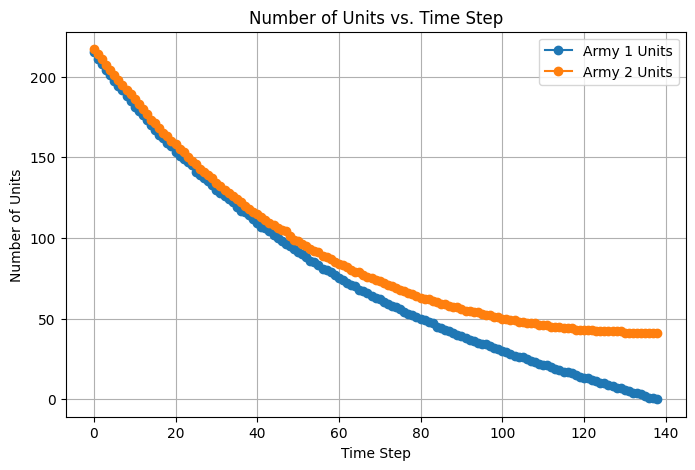

In [ ]:

#This version uses target precedence lists
import random
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
SCALE_EFFICIENCY = True  # Set to False to disable scaling by health

# -----------------------------
# Unit Class Definition
# -----------------------------
class Unit:
    def __init__(self, unit_type, health, efficiencies):
        self.unit_type = unit_type
        self.health = health
        self.max_health = health
        self.efficiencies = efficiencies

    def __repr__(self):
        return f"{self.unit_type}(HP:{self.health})"

# -----------------------------
# Helper: Get Scaled Efficiency
# -----------------------------
def get_scaled_efficiency(attacker, target_type):
    base_eff = attacker.efficiencies.get(target_type, 0)
    if SCALE_EFFICIENCY:
        return base_eff * (attacker.health / attacker.max_health)
    return base_eff

# -----------------------------
# Helper: Damage Allocation (Killable Feature)
# -----------------------------
def allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose=False):
    damage_left = attack_power
    while damage_left > 0 and ordered_targets:
        killable = [enemy for enemy in ordered_targets if remaining_health[enemy] <= damage_left]
        if killable:
            for enemy in ordered_targets:
                if remaining_health[enemy] <= damage_left:
                    alloc = remaining_health[enemy]
                    allocated_damage[enemy] += alloc
                    damage_left -= alloc
                    remaining_health[enemy] = 0
                    if verbose:
                        print(f"    Allocated {alloc} damage to {enemy} (killed)")
                    ordered_targets.remove(enemy)
                    break
        else:
            enemy = ordered_targets[0]
            alloc = min(damage_left, remaining_health[enemy])
            allocated_damage[enemy] += alloc
            remaining_health[enemy] -= alloc
            damage_left -= alloc
            if verbose:
                print(f"    Allocated {alloc} damage to {enemy} (not killed)")
            if remaining_health[enemy] <= 0:
                ordered_targets.remove(enemy)
    return allocated_damage

# -----------------------------
# Target Precedence Policy Factory with Scaling
# -----------------------------
def make_target_precedence_policy_with_scaling(precedence_mapping):
    def policy(attacking_army, enemy_army, verbose=False):
        allocated_damage = {enemy: 0 for enemy in enemy_army}
        remaining_health = {enemy: enemy.health for enemy in enemy_army}
        attackers = list(attacking_army)
        random.shuffle(attackers)
        for attacker in attackers:
            available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0]
            if not available:
                continue

            precedence = precedence_mapping.get(attacker.unit_type, [])

            def sort_key(enemy):
                try:
                    index = precedence.index(enemy.unit_type)
                except ValueError:
                    index = float('inf')
                return (index, enemy.health)

            ordered_targets = sorted(available, key=sort_key)
            attack_power = max(
                get_scaled_efficiency(attacker, t) for t in attacker.efficiencies
            )
            if verbose:
                print(f"{attacker} (power {attack_power:.2f}) targeting order: {ordered_targets}")
            allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
        return allocated_damage
    return policy

# -----------------------------
# Simulation Function
# -----------------------------
def simulate_combat(army1, army2, policy_army1, policy_army2, verbose=False):
    step = 0
    history = {'steps': [], 'army1_counts': [], 'army2_counts': []}
    history['steps'].append(step)
    history['army1_counts'].append(len(army1))
    history['army2_counts'].append(len(army2))

    while army1 and army2:
        if verbose:
            print(f"\nTime Step {step}:")
            print(f" Army1: {army1}")
            print(f" Army2: {army2}")

        damage_to_army2 = policy_army1(army1, army2, verbose=verbose)
        damage_to_army1 = policy_army2(army2, army1, verbose=verbose)

        new_army1 = []
        for unit in army1:
            dmg = damage_to_army1.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army1 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army1.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")

        new_army2 = []
        for unit in army2:
            dmg = damage_to_army2.get(unit, 0)
            unit.health -= dmg
            if verbose:
                print(f" {unit} from Army2 takes {dmg} damage, new HP: {unit.health}")
            if unit.health > 0:
                new_army2.append(unit)
            else:
                if verbose:
                    print(f" {unit} is destroyed!")

        army1, army2 = new_army1, new_army2
        step += 1
        history['steps'].append(step)
        history['army1_counts'].append(len(army1))
        history['army2_counts'].append(len(army2))

    return step, army1, army2, history

# -----------------------------
# Main Function
# -----------------------------
def main():
    global SCALE_EFFICIENCY
    SCALE_EFFICIENCY = True  # Set to False if you want fixed attack power

    # Define Army 1
    army1 = (
        [Unit("INF", 120, {"INF": 1, "MBT": 0.5, "DRN": 2}) for _ in range(200)] +
        [Unit("MBT", 200, {"INF": 2, "MBT": 2, "DRN": 1}) for _ in range(8)] +
        [Unit("ADT", 100, {"INF": 1, "MBT": 1, "DRN": 3}) for _ in range(7)]
    )

    # Define Army 2
    army2 = (
        [Unit("INF", 120, {"INF": 1, "MBT": 0.5, "ADT": 2}) for _ in range(200)] +
        [Unit("MBT", 180, {"INF": 2, "MBT": 1.5, "ADT": 1}) for _ in range(7)] +
        [Unit("DRN", 80, {"INF": 3, "MBT": 1, "ADT": 2}) for _ in range(10)]
    )

    # Target Precedence Maps
    army1_precedence = {
        "INF": ["INF", "MBT", "DRN"],
        "MBT": ["MBT", "INF", "DRN"],
        "ADT": ["DRN", "INF", "MBT"]
    }

    army2_precedence = {
        "INF": ["ADT", "INF", "MBT"],
        "MBT": ["MBT", "INF", "ADT"],
        "DRN": ["MBT", "ADT", "INF"]
    }

    policy_army1 = make_target_precedence_policy_with_scaling(army1_precedence)
    policy_army2 = make_target_precedence_policy_with_scaling(army2_precedence)

    steps, remaining_army1, remaining_army2, history = simulate_combat(
        army1, army2, policy_army1, policy_army2, verbose=False
    )

    print(f"\nCombat ended after {steps} time steps.")
    if remaining_army1:
        print("Army1 wins with surviving units:")
        print(remaining_army1)
        print(len(remaining_army1))
    elif remaining_army2:
        print("Army2 wins with surviving units:")
        print(remaining_army2)
        print(len(remaining_army2))
    else:
        print("Both armies have been completely destroyed.")

    # Plot unit counts over time
    plt.figure(figsize=(8, 5))
    plt.plot(history['steps'], history['army1_counts'], marker='o', label="Army 1 Units")
    plt.plot(history['steps'], history['army2_counts'], marker='o', label="Army 2 Units")
    plt.xlabel("Time Step")
    plt.ylabel("Number of Units")
    plt.title("Number of Units vs. Time Step")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()


In [ ]:
#Tests all permutations of precedence lists.
#Infeasible to run when each army has more than 2 types (2 and 3 might still work althought it is still 288 simulations)
import random
import itertools
import pandas as pd
from collections import defaultdict

SCALE_EFFICIENCY = False

class Unit:
    def __init__(self, unit_type, health, efficiencies):
        self.unit_type = unit_type
        self.health = health
        self.max_health = health
        self.efficiencies = efficiencies

    def __repr__(self):
        return f"{self.unit_type}(HP:{self.health})"

def get_scaled_efficiency(attacker, target_type):
    base_eff = attacker.efficiencies.get(target_type, 0)
    if SCALE_EFFICIENCY:
        return base_eff * (attacker.health / attacker.max_health)
    return base_eff

def allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose=False):
    damage_left = attack_power
    while damage_left > 0 and ordered_targets:
        killable = [enemy for enemy in ordered_targets if remaining_health[enemy] <= damage_left]
        if killable:
            for enemy in ordered_targets:
                if remaining_health[enemy] <= damage_left:
                    alloc = remaining_health[enemy]
                    allocated_damage[enemy] += alloc
                    damage_left -= alloc
                    remaining_health[enemy] = 0
                    ordered_targets.remove(enemy)
                    break
        else:
            enemy = ordered_targets[0]
            alloc = min(damage_left, remaining_health[enemy])
            allocated_damage[enemy] += alloc
            remaining_health[enemy] -= alloc
            damage_left -= alloc
            if remaining_health[enemy] <= 0:
                ordered_targets.remove(enemy)
    return allocated_damage

def make_target_precedence_policy(precedence_mapping):
    def policy(attacking_army, enemy_army, verbose=False):
        allocated_damage = {enemy: 0 for enemy in enemy_army}
        remaining_health = {enemy: enemy.health for enemy in enemy_army}
        attackers = list(attacking_army)
        random.shuffle(attackers)
        for attacker in attackers:
            available = [enemy for enemy in enemy_army if remaining_health[enemy] > 0]
            if not available:
                continue

            precedence = precedence_mapping.get(attacker.unit_type, [])

            def sort_key(enemy):
                try:
                    index = precedence.index(enemy.unit_type)
                except ValueError:
                    index = float('inf')
                return (index, enemy.health)

            ordered_targets = sorted(available, key=sort_key)
            attack_power = max(
                get_scaled_efficiency(attacker, t) for t in attacker.efficiencies
            )
            allocate_damage_to_targets(ordered_targets, attack_power, allocated_damage, remaining_health, verbose)
        return allocated_damage
    return policy

def simulate_combat(army1, army2, policy_army1, policy_army2):
    step = 0
    while army1 and army2:
        damage_to_army2 = policy_army1(army1, army2)
        damage_to_army1 = policy_army2(army2, army1)

        new_army1 = []
        for unit in army1:
            unit.health -= damage_to_army1.get(unit, 0)
            if unit.health > 0:
                new_army1.append(unit)
        new_army2 = []
        for unit in army2:
            unit.health -= damage_to_army2.get(unit, 0)
            if unit.health > 0:
                new_army2.append(unit)

        army1, army2 = new_army1, new_army2
        step += 1

    return len(army1), len(army2)

def generate_precedence_mappings(unit_types, target_types):
    permutations = list(itertools.permutations(target_types))
    all_mappings = []
    for combo in itertools.product(permutations, repeat=len(unit_types)):
        mapping = {unit: list(order) for unit, order in zip(unit_types, combo)}
        all_mappings.append(mapping)
    return all_mappings

def create_army1():
    return (
        [Unit("INF", 1000, {"INF": 1, "MBT": 0.5}) for _ in range(200)] +
        [Unit("MBT", 5000, {"INF": 2, "MBT": 2}) for _ in range(10)]
    )

def create_army2():

    return (
        [Unit("INF", 1000, {"INF": 1, "MBT": 0.5}) for _ in range(200)] +
        [Unit("MBT", 5000, {"INF": 2, "MBT": 2}) for _ in range(10)]
    )
def precedence_key(precedence_map):
    return tuple((k, tuple(v)) for k, v in sorted(precedence_map.items()))

def main():
    army1_types = ["INF", "MBT"]
    army2_types = ["INF", "MBT"]

    army1_permutations = generate_precedence_mappings(army1_types, army2_types)
    army2_permutations = generate_precedence_mappings(army2_types, army1_types)

    results = {}

    total = len(army1_permutations) * len(army2_permutations)
    count = 0

    for i, army1_prec in enumerate(army1_permutations):
        for j, army2_prec in enumerate(army2_permutations):
            army1 = create_army1()
            army2 = create_army2()
            policy1 = make_target_precedence_policy(army1_prec)
            policy2 = make_target_precedence_policy(army2_prec)
            result = simulate_combat(army1, army2, policy1, policy2)

            key1 = precedence_key(army1_prec)
            key2 = precedence_key(army2_prec)
            results[(key1, key2)] = result

            count += 1
            if count % 100 == 0 or count == total:
                print(f"Simulated {count}/{total}")

    # Convert results to DataFrame
    row_keys = sorted(set(k[0] for k in results))
    col_keys = sorted(set(k[1] for k in results))

    data = []
    for row in row_keys:
        row_data = []
        for col in col_keys:
            row_data.append(results.get((row, col), (None, None)))
        data.append(row_data)

    df = pd.DataFrame(data, index=row_keys, columns=col_keys)
    df.to_pickle("simulation_results.pkl")
    print("Saved results to 'simulation_results.pkl'")

if __name__ == "__main__":
    main()


Simulated 16/16
Saved results to 'simulation_results.pkl'


In [ ]:
import pandas as pd
df = pd.read_pickle("simulation_results.pkl")
print(df)

                                       ((INF, (INF, MBT)), (MBT, (INF, MBT)))  \
((INF, (INF, MBT)), (MBT, (INF, MBT)))                                 (0, 0)   
((INF, (INF, MBT)), (MBT, (MBT, INF)))                                (0, 69)   
((INF, (MBT, INF)), (MBT, (INF, MBT)))                               (0, 109)   
((INF, (MBT, INF)), (MBT, (MBT, INF)))                               (0, 109)   

                                       ((INF, (INF, MBT)), (MBT, (MBT, INF)))  \
((INF, (INF, MBT)), (MBT, (INF, MBT)))                                (69, 0)   
((INF, (INF, MBT)), (MBT, (MBT, INF)))                                 (0, 2)   
((INF, (MBT, INF)), (MBT, (INF, MBT)))                               (0, 104)   
((INF, (MBT, INF)), (MBT, (MBT, INF)))                               (0, 105)   

                                       ((INF, (MBT, INF)), (MBT, (INF, MBT)))  \
((INF, (INF, MBT)), (MBT, (INF, MBT)))                               (109, 0)   
((INF, (INF, MBT)), (MBT, 